# **Stock Price Prediction Using LSTM Models**

This project focuses on predicting the stock prices of Apple, Google, and Microsoft using Long Short-Term Memory (LSTM) models. Historical stock data was retrieved from Yahoo Finance, analyzed, and visualized. LSTM models were then built, trained, and evaluated for each company. The predicted stock prices were compared with the actual prices, and the trained models were saved for future use.

## objective:

To develop and evaluate LSTM models for predicting the stock prices of major technology companies (Apple, Google, and Microsoft) and to compare the performance of these models.

## Steps:
1. **Data Acquisition:**
- Download historical stock data for Apple (AAPL), Google (GOOGL), and Microsoft (MSFT) from Yahoo Finance.
2. **Data Analysis and Visualization:**
- Analyze the downloaded data to understand trends and patterns.
- Visualize the data using appropriate charts and graphs.
3. **LSTM Model Development:**
- Build LSTM models for each of the three companies.
- Prepare the data for input into the LSTM models.
3. **Model Training:**
- Train the LSTM models using the historical stock data.
3. **Model Evaluation:**
- Evaluate the performance of the trained models by comparing the predicted stock prices with the actual prices.
- Compare the performance of the models between the 3 companies.
Results and Comparison:
- Document the results of the prediction.
- Compare the results between the three companies.
4. **Model Saving:**
- Save the trained LSTM models for future use.

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)


In [120]:
!pip install --upgrade yfinance==0.2.54

In [121]:
import yfinance as yf
print(yf.__version__)

0.2.54


In [122]:
!python --version

Python 3.11.11


In [123]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix

# **Data Scrapping**

In [124]:
import yfinance as yf
import pandas as pd

def get_yahoo_historical_data(ticker, start_date="2010-01-01", end_date="2025-01-01"):
    """
    Fetches historical stock data for a given company from Yahoo Finance.
    """
    stock = yf.Ticker(ticker)
    hist = stock.history(start=start_date, end=end_date)

    if hist.empty:
        print(f"No data found for {ticker}")
        return None


    hist.reset_index(inplace=True)
    hist["Date"] = hist["Date"].dt.strftime('%Y-%m-%d %H:%M:%S')


    hist = hist[["Date", "Open", "Close", "High", "Low", "Volume"]]
    hist.rename(columns={
        "Open": "Open Price",
        "Close": "Close Price",
        "High": "High Price",
        "Low": "Low Price",
        "Volume": "Volume"
    }, inplace=True)

    return hist

def save_company_data(tickers):
    """
    Fetches and saves historical stock data for each company as a separate CSV file.
    """
    for ticker in tickers:
        print(f"Fetching data for {ticker}...")
        data = get_yahoo_historical_data(ticker)

        if data is not None:
            filename = f"{ticker.lower()}.csv"
            data.to_csv(filename, index=False)
            print(f" Data saved: {filename}")
        else:
            print(f" Skipping {ticker} due to missing data.")

# example
company_tickers = ["AAPL", "GOOGL", "MSFT"]
save_company_data(company_tickers)


Fetching data for AAPL...
 Data saved: aapl.csv
Fetching data for GOOGL...
 Data saved: googl.csv
Fetching data for MSFT...
 Data saved: msft.csv


# **Uploading Apple, google, and microsoft data**

In [125]:
apple_data = pd.read_csv("aapl.csv")
apple_data.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume
0,2010-01-04 00:00:00,6.422877,6.440331,6.455077,6.391278,493729600
1,2010-01-05 00:00:00,6.458087,6.451467,6.487880,6.417460,601904800
2,2010-01-06 00:00:00,6.451466,6.348847,6.477046,6.342226,552160000
3,2010-01-07 00:00:00,6.372320,6.337111,6.379844,6.291067,477131200
4,2010-01-08 00:00:00,6.328684,6.379241,6.379843,6.291368,447610800


In [126]:
google_data = pd.read_csv("googl.csv")
google_data.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume
0,2010-01-04 00:00:00,15.632768,15.627781,15.696601,15.565196,78169752
1,2010-01-05 00:00:00,15.638504,15.558962,15.654961,15.497873,120067812
2,2010-01-06 00:00:00,15.605590,15.166740,15.605590,15.119365,158988852
3,2010-01-07 00:00:00,15.195166,14.813666,15.210128,14.777512,256315428
4,2010-01-08 00:00:00,14.761303,15.011148,15.041817,14.689241,188783028


In [127]:
microsoft_data = pd.read_csv("msft.csv")
microsoft_data.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume
0,2010-01-04 00:00:00,23.006101,23.254044,23.366745,22.983560,38409100
1,2010-01-05 00:00:00,23.178921,23.261568,23.366757,23.021139,49749600
2,2010-01-06 00:00:00,23.201457,23.118811,23.351726,22.930975,58182400
3,2010-01-07 00:00:00,23.013615,22.878374,23.066210,22.683025,50559700
4,2010-01-08 00:00:00,22.750648,23.036158,23.201452,22.720594,51197400


# **Exploratory Data Analysis (EDA)**

In [128]:
apple_data.shape
apple_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         3774 non-null   object 
 1   Open Price   3774 non-null   float64
 2   Close Price  3774 non-null   float64
 3   High Price   3774 non-null   float64
 4   Low Price    3774 non-null   float64
 5   Volume       3774 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 177.0+ KB


In [129]:
google_data.shape
google_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         3774 non-null   object 
 1   Open Price   3774 non-null   float64
 2   Close Price  3774 non-null   float64
 3   High Price   3774 non-null   float64
 4   Low Price    3774 non-null   float64
 5   Volume       3774 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 177.0+ KB


In [130]:
microsoft_data.shape
microsoft_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         3774 non-null   object 
 1   Open Price   3774 non-null   float64
 2   Close Price  3774 non-null   float64
 3   High Price   3774 non-null   float64
 4   Low Price    3774 non-null   float64
 5   Volume       3774 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 177.0+ KB


In [131]:
apple_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Open Price,3774.0,6.746551e+01,6.552384e+01,5.789106e+00,1.746528e+01,3.535474e+01,1.263391e+02,2.579064e+02
Close Price,3774.0,6.752169e+01,6.560267e+01,5.779476e+00,1.746168e+01,3.532372e+01,1.269096e+02,2.587355e+02
High Price,3774.0,6.817623e+01,6.621238e+01,5.898345e+00,1.764544e+01,3.572875e+01,1.279992e+02,2.598143e+02
Low Price,3774.0,6.679725e+01,6.490410e+01,5.725307e+00,1.731601e+01,3.496334e+01,1.248278e+02,2.573470e+02
Volume,3774.0,2.299200e+08,2.180726e+08,2.323470e+07,8.492275e+07,1.403920e+08,3.081386e+08,1.880998e+09


In [132]:
google_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Open Price,3774.0,6.119866e+01,4.666640e+01,1.092910e+01,2.262693e+01,4.719516e+01,9.342520e+01,1.972500e+02
Close Price,3774.0,6.122020e+01,4.669207e+01,1.087325e+01,2.260749e+01,4.720612e+01,9.358076e+01,1.966600e+02
High Price,3774.0,6.183402e+01,4.719860e+01,1.102809e+01,2.276439e+01,4.746493e+01,9.487071e+01,2.014200e+02
Low Price,3774.0,6.057955e+01,4.617490e+01,1.081241e+01,2.245152e+01,4.683273e+01,9.191916e+01,1.949800e+02
Volume,3774.0,5.617230e+07,4.749974e+07,9.312000e+06,2.733450e+07,3.768900e+07,7.315977e+07,5.923990e+08


In [133]:
microsoft_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Open Price,3774.0,1.295472e+02,1.249776e+02,1.750827e+01,2.876603e+01,6.485277e+01,2.288504e+02,4.642976e+02
Close Price,3774.0,1.295783e+02,1.249879e+02,1.744761e+01,2.877219e+01,6.498546e+01,2.285354e+02,4.648543e+02
High Price,3774.0,1.307709e+02,1.261048e+02,1.768267e+01,2.898182e+01,6.542931e+01,2.312545e+02,4.656398e+02
Low Price,3774.0,1.282649e+02,1.237617e+02,1.723530e+01,2.857896e+01,6.433112e+01,2.255114e+02,4.617723e+02
Volume,3774.0,3.616344e+07,2.085042e+07,7.164500e+06,2.262030e+07,3.022110e+07,4.420790e+07,3.193179e+08


In [134]:
print("Apple data types:", apple_data.dtypes)
print("Google data types:", google_data.dtypes)
print("Microsoft data types:", microsoft_data.dtypes)

Apple data types: Date            object
Open Price     float64
Close Price    float64
High Price     float64
Low Price      float64
Volume           int64
dtype: object
Google data types: Date            object
Open Price     float64
Close Price    float64
High Price     float64
Low Price      float64
Volume           int64
dtype: object
Microsoft data types: Date            object
Open Price     float64
Close Price    float64
High Price     float64
Low Price      float64
Volume           int64
dtype: object


------------------------------------------------------------------------------------------------


# **Date Column**

In [135]:
apple_data["Date"] = pd.to_datetime(apple_data["Date"])
print(apple_data.dtypes)

Date           datetime64[ns]
Open Price            float64
Close Price           float64
High Price            float64
Low Price             float64
Volume                  int64
dtype: object


In [136]:
google_data["Date"] = pd.to_datetime(google_data["Date"])
print(google_data.dtypes)

Date           datetime64[ns]
Open Price            float64
Close Price           float64
High Price            float64
Low Price             float64
Volume                  int64
dtype: object


In [137]:
microsoft_data["Date"] = pd.to_datetime(microsoft_data["Date"])
print(microsoft_data.dtypes)

Date           datetime64[ns]
Open Price            float64
Close Price           float64
High Price            float64
Low Price             float64
Volume                  int64
dtype: object


# **Null and Duplicated Values**

In [138]:
#is there any missing values (Aplle Data)
if apple_data.isnull().sum().any():
 print("yes")
else:
    print("No")

No


In [139]:
#is there any dupilacted values (Apple Data)
if apple_data.duplicated().any():
    print("yes")
else:
    print("No")

No


In [140]:
#is there any missing values (google Data)
if google_data.isnull().sum().any():
 print("yes")
else:
    print("No")

No


In [141]:
#is there any dupilacted values (google Data)
if google_data.duplicated().any():
    print("yes")
else:
    print("No")

No


In [142]:
#is there any dupilacted values (microsoft Data)
if microsoft_data.duplicated().any():
    print("yes")
else:
    print("No")

No


In [143]:
#is there any dupilacted values (microsoft Data)
if microsoft_data.duplicated().any():
    print("yes")
else:
    print("No")

No


----------------------------------------------------------------------


In [144]:
unique = apple_data.nunique().sort_values()
unique_values = apple_data.apply(lambda x: x.unique())
pd.DataFrame({'Number of Unique Values': unique, 'Unique Values': unique_values})

,Number of Unique Values,Unique Values
Close Price,3722,"[6.440330982208252, 6.4514665603637695, 6.3488..."
Date,3774,"[2010-01-04 00:00:00, 2010-01-05 00:00:00, 201..."
High Price,3774,"[6.455076781226995, 6.487879848401319, 6.47704..."
Low Price,3774,"[6.391278499172716, 6.417460413781116, 6.34222..."
Open Price,3774,"[6.422876697326148, 6.458087304295299, 6.45146..."
Volume,3765,"[493729600, 601904800, 552160000, 477131200, 4..."


In [145]:
unique = google_data.nunique().sort_values()
unique_values = google_data.apply(lambda x: x.unique())
pd.DataFrame({'Number of Unique Values': unique, 'Unique Values': unique_values})

,Number of Unique Values,Unique Values
Close Price,3725,"[15.62778091430664, 15.558961868286133, 15.166..."
Date,3774,"[2010-01-04 00:00:00, 2010-01-05 00:00:00, 201..."
High Price,3774,"[15.69660129259785, 15.654960715760703, 15.605..."
Low Price,3774,"[15.565195942606344, 15.497872556465603, 15.11..."
Open Price,3774,"[15.632767719212024, 15.638503689031095, 15.60..."
Volume,3662,"[78169752, 120067812, 158988852, 256315428, 18..."


In [146]:
unique = microsoft_data.nunique().sort_values()
unique_values = microsoft_data.apply(lambda x: x.unique())
pd.DataFrame({'Number of Unique Values': unique, 'Unique Values': unique_values})

,Number of Unique Values,Unique Values
Close Price,3591,"[23.25404357910156, 23.261568069458008, 23.118..."
Date,3774,"[2010-01-04 00:00:00, 2010-01-05 00:00:00, 201..."
High Price,3766,"[23.36674463177257, 23.36675701636412, 23.3517..."
Low Price,3771,"[22.98355990623385, 23.02113864751101, 22.9309..."
Open Price,3770,"[23.006100689996703, 23.178921351333976, 23.20..."
Volume,3761,"[38409100, 49749600, 58182400, 50559700, 51197..."


# **Correlation**

In [147]:
correlation_matrix_apple = apple_data.select_dtypes(include=['float64', 'int64']).corr().round(2)
print(correlation_matrix_apple)

             Open Price  Close Price  High Price  Low Price  Volume
Open Price         1.00         1.00        1.00       1.00   -0.54
Close Price        1.00         1.00        1.00       1.00   -0.54
High Price         1.00         1.00        1.00       1.00   -0.54
Low Price          1.00         1.00        1.00       1.00   -0.54
Volume            -0.54        -0.54       -0.54      -0.54    1.00


In [148]:
correlation_matrix_google = google_data.select_dtypes(include=['float64', 'int64']).corr().round(2)
print(correlation_matrix_google)

             Open Price  Close Price  High Price  Low Price  Volume
Open Price         1.00         1.00        1.00       1.00   -0.48
Close Price        1.00         1.00        1.00       1.00   -0.48
High Price         1.00         1.00        1.00       1.00   -0.48
Low Price          1.00         1.00        1.00       1.00   -0.48
Volume            -0.48        -0.48       -0.48      -0.48    1.00


In [149]:
correlation_matrix_microsoft = microsoft_data.select_dtypes(include=['float64', 'int64']).corr().round(2)
print(correlation_matrix_microsoft)

             Open Price  Close Price  High Price  Low Price  Volume
Open Price         1.00         1.00        1.00       1.00   -0.38
Close Price        1.00         1.00        1.00       1.00   -0.38
High Price         1.00         1.00        1.00       1.00   -0.38
Low Price          1.00         1.00        1.00       1.00   -0.38
Volume            -0.38        -0.38       -0.38      -0.38    1.00


-------------------------

# **Analysing Apple Data**

In [150]:
apple_data.columns

Index(['Date', 'Open Price', 'Close Price', 'High Price', 'Low Price',
       'Volume'],
      dtype='object')

In [151]:
days_above_150_apple = apple_data.query("`Close Price` > 150").shape[0]
print(f"Number of days Apple closed above $150: {days_above_150_apple}")

Number of days Apple closed above $150: 636


In [152]:
days_under_100_apple = apple_data.query("`Close Price` < 100").shape[0]
print(f"Number of days Apple closed below $100: {days_under_100_apple}")

Number of days Apple closed below $100: 2662


In [153]:
highest_close_apple = apple_data["Close Price"].max()
lowest_close_apple = apple_data["Close Price"].min()
print(f"Highest closing price: ${highest_close_apple}")
print(f"Lowest closing price: ${lowest_close_apple}")

Highest closing price: $258.7355041503906
Lowest closing price: $5.779476165771484


In [154]:
price_range_apple = highest_close_apple - lowest_close_apple
print(f"Price range between highest and lowest closing prices: ${price_range_apple}")

Price range between highest and lowest closing prices: $252.95602798461914


In [155]:
average_close_apple= apple_data["Close Price"].mean()
print(f"Average closing price: ${average_close_apple:.2f}")

Average closing price: $67.52


In [156]:
highest_close_date_apple = apple_data.loc[apple_data["Close Price"].idxmax(), "Date"]
print(f"Date of highest close: {highest_close_date_apple}")

Date of highest close: 2024-12-26 00:00:00


# **Analysing Google Data**

In [157]:
google_data.columns

Index(['Date', 'Open Price', 'Close Price', 'High Price', 'Low Price',
       'Volume'],
      dtype='object')

In [158]:
days_above_150_google = google_data.query("`Close Price` > 150").shape[0]
print(f"Number of days Google closed above $150: {days_above_150_google}")

Number of days Google closed above $150: 196


In [159]:
days_under_100_google = google_data.query("`Close Price` < 100").shape[0]
print(f"Number of days Google closed below $100: {days_under_100_google}")

Number of days Google closed below $100: 2897


In [160]:
highest_close_google = google_data["Close Price"].max()
lowest_close_google = google_data["Close Price"].min()
print(f"Highest closing price: ${highest_close_google}")
print(f"Lowest closing price: ${lowest_close_google}")

Highest closing price: $196.66000366210935
Lowest closing price: $10.873247146606444


In [161]:
price_range_google= highest_close_google - lowest_close_google
print(f"Price range between highest and lowest closing prices: ${price_range_google}")

Price range between highest and lowest closing prices: $185.7867565155029


In [162]:
average_close_google = google_data["Close Price"].mean()
print(f"Average closing price: ${average_close_google:.2f}")

Average closing price: $61.22


In [163]:
highest_close_date_google = google_data.loc[google_data["Close Price"].idxmax(), "Date"]
print(f"Date of highest close: {highest_close_date_google}")

Date of highest close: 2024-12-16 00:00:00


# **Analysing Microsoft Data**

In [164]:
microsoft_data.columns

Index(['Date', 'Open Price', 'Close Price', 'High Price', 'Low Price',
       'Volume'],
      dtype='object')

In [165]:
days_above_150_microsoft = microsoft_data.query("`Close Price` > 150").shape[0]
print(f"Number of days Microsoft closed above $150: {days_above_150_microsoft}")

Number of days Microsoft closed above $150: 1249


In [166]:
days_under_100_microsoft = microsoft_data.query("`Close Price` < 100").shape[0]
print(f"Number of days Microsoft closed below $100: {days_under_100_microsoft}")

Number of days Microsoft closed below $100: 2203


In [167]:
highest_close_microsoft = google_data["Close Price"].max()
lowest_close_microsoft = google_data["Close Price"].min()
print(f"Highest closing price: ${highest_close_microsoft}")
print(f"Lowest closing price: ${lowest_close_microsoft}")

Highest closing price: $196.66000366210935
Lowest closing price: $10.873247146606444


In [168]:
price_range_microsoft= highest_close_microsoft - lowest_close_microsoft
print(f"Price range between highest and lowest closing prices: ${price_range_microsoft}")

Price range between highest and lowest closing prices: $185.7867565155029


In [169]:
average_close_microsoft = microsoft_data["Close Price"].mean()
print(f"Average closing price: ${average_close_microsoft:.2f}")

Average closing price: $129.58


In [170]:
highest_close_date_microsoft = microsoft_data.loc[microsoft_data["Close Price"].idxmax(), "Date"]
print(f"Date of highest close: {highest_close_date_microsoft}")

Date of highest close: 2024-07-05 00:00:00


# **Outliers**

In [171]:
Q1 = apple_data.quantile(0.25)
Q3 = apple_data.quantile(0.75)
IQR = Q3 - Q1

outliers = ((apple_data < (Q1 - 1.5 * IQR)) | (apple_data > (Q3 + 1.5 * IQR))).sum()
pd.DataFrame({'Number of Outliers in Apple data': outliers})

,Number of Outliers in Apple data
Date,0
Open Price,0
Close Price,0
High Price,0
Low Price,0
Volume,212


In [172]:
Q1 = google_data.quantile(0.25)
Q3 = google_data.quantile(0.75)
IQR = Q3 - Q1

outliers = ((google_data < (Q1 - 1.5 * IQR)) | (google_data > (Q3 + 1.5 * IQR))).sum()
pd.DataFrame({'Number of Outliers in Google Data': outliers})

,Number of Outliers in Google Data
Date,0
Open Price,0
Close Price,0
High Price,0
Low Price,0
Volume,175


In [173]:
Q1 = google_data.quantile(0.25)
Q3 = microsoft_data.quantile(0.75)
IQR = Q3 - Q1

outliers = ((microsoft_data < (Q1 - 1.5 * IQR)) | (microsoft_data > (Q3 + 1.5 * IQR))).sum()
pd.DataFrame({'Number of Outliers in Microsoft': outliers})

,Number of Outliers in Microsoft
Date,0
Open Price,0
Close Price,0
High Price,0
Low Price,0
Volume,227


---------------

# **Data Visualization**

## **Apple**

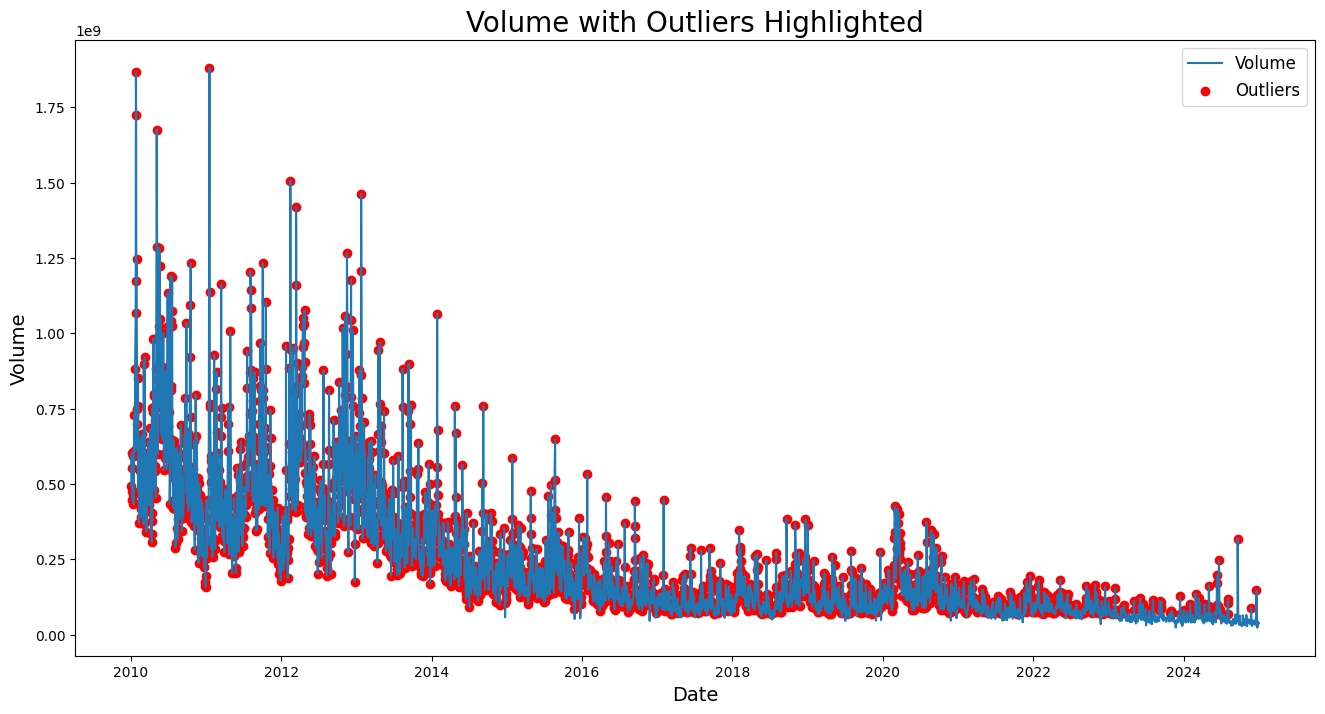

In [174]:
plt.figure(figsize=(16, 8))
sns.lineplot(x=apple_data['Date'], y=apple_data['Volume'], label='Volume')
outlier_dates = apple_data[apple_data['Volume'] > (Q3['Volume'] + 1.5 * IQR['Volume'])].index
plt.scatter(apple_data['Date'].iloc[outlier_dates], apple_data['Volume'].iloc[outlier_dates], color='red', label='Outliers')
plt.title('Volume with Outliers Highlighted', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.legend(fontsize=12)

Text(0.5, 1.0, 'Histogram of Stock Closing Prices')

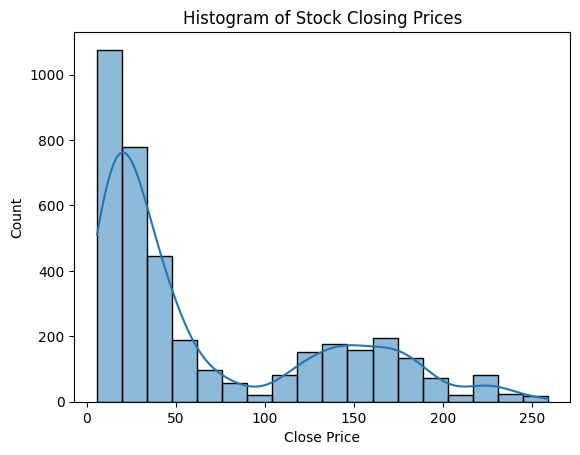

In [175]:
sns.histplot(apple_data['Close Price'], kde=True)  # kde=True adds a density curve
plt.title('Histogram of Stock Closing Prices')

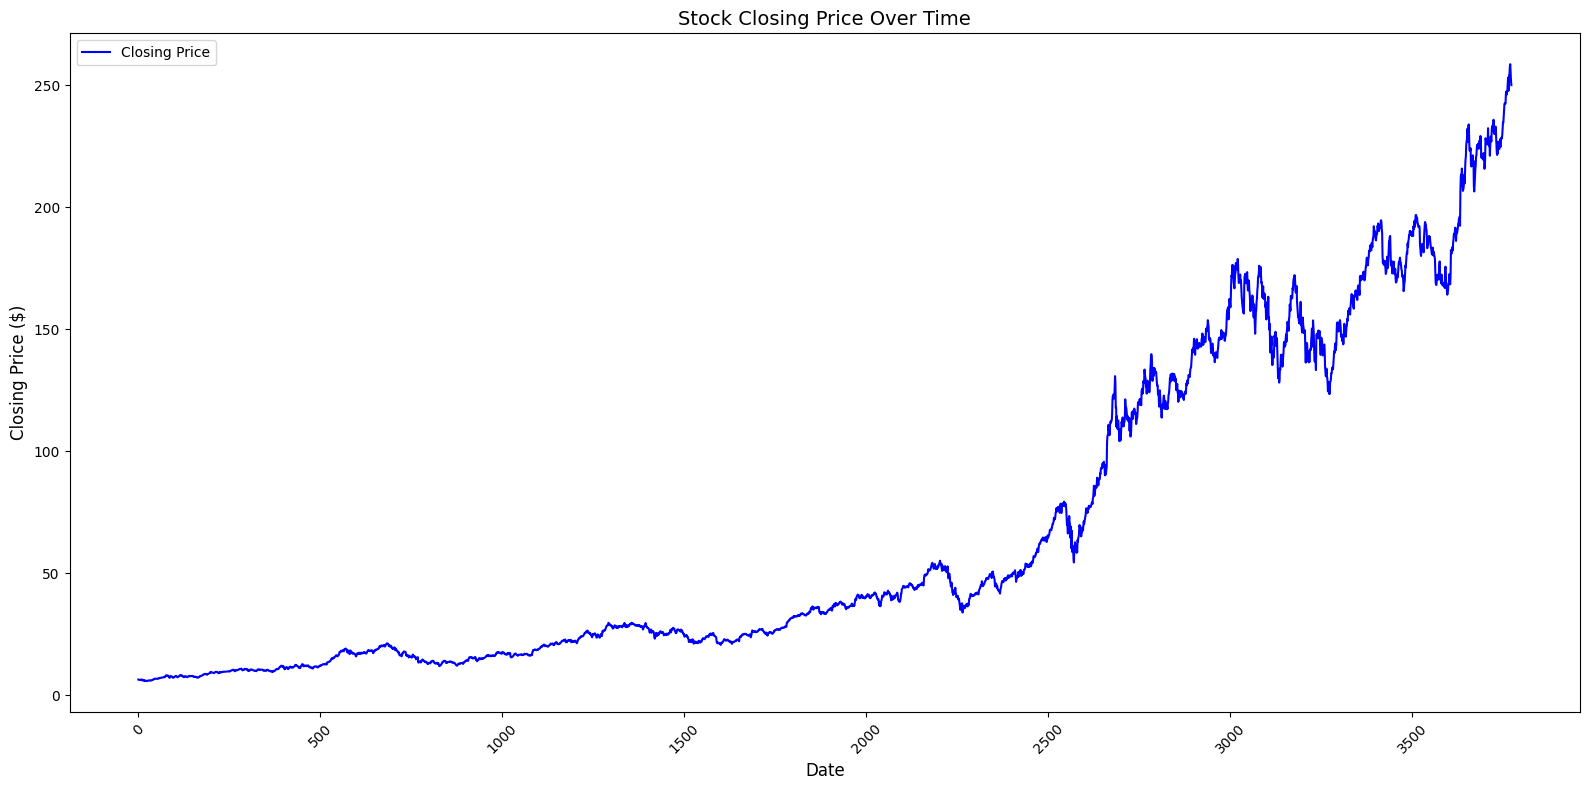

In [176]:
plt.figure(figsize=(16, 8))
plt.plot(apple_data.index, apple_data['Close Price'], label='Closing Price', color='blue')
plt.title('Stock Closing Price Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price ($)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

Text(0.5, 1.0, 'Apple Trading Volume (1J024 - 1\x02\x825)')

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2 () missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


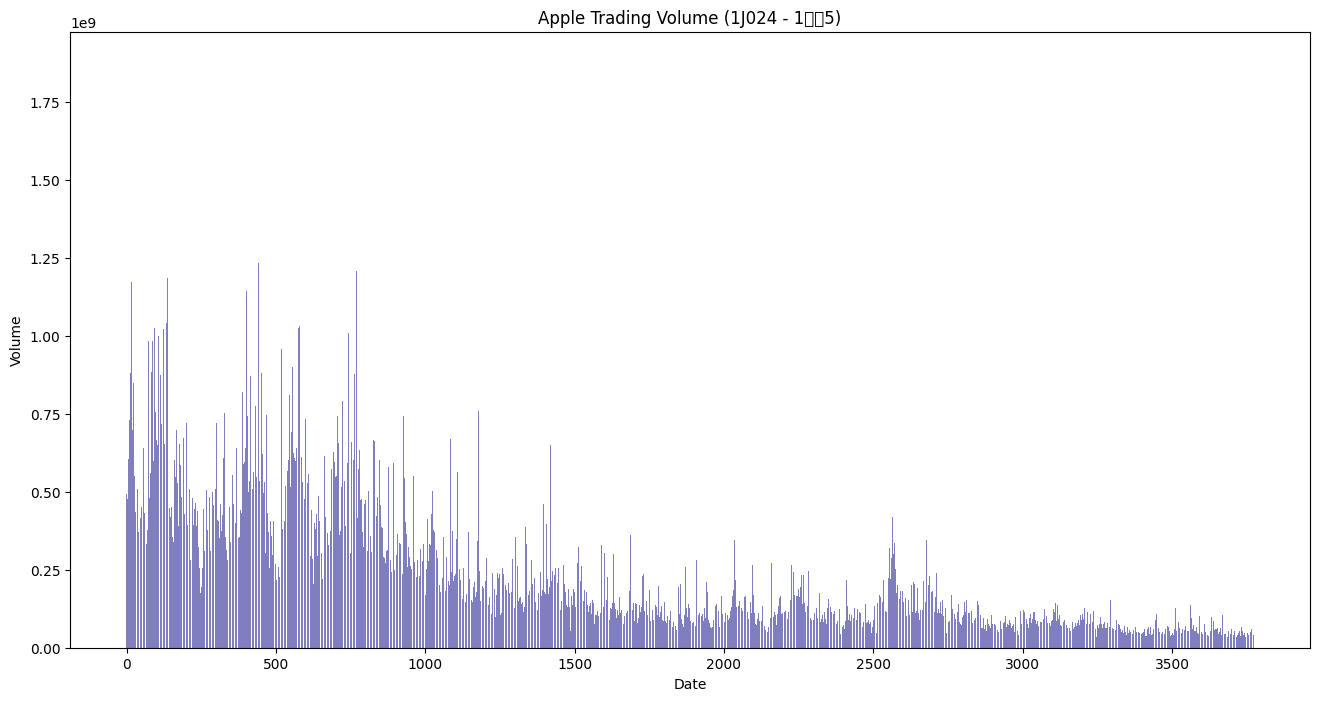

In [177]:
plt.figure(figsize=(16, 8))
plt.bar(apple_data.index, apple_data["Volume"], color='navy', alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Apple Trading Volume (1\112024 - 1\2\2025)")

## **Google**

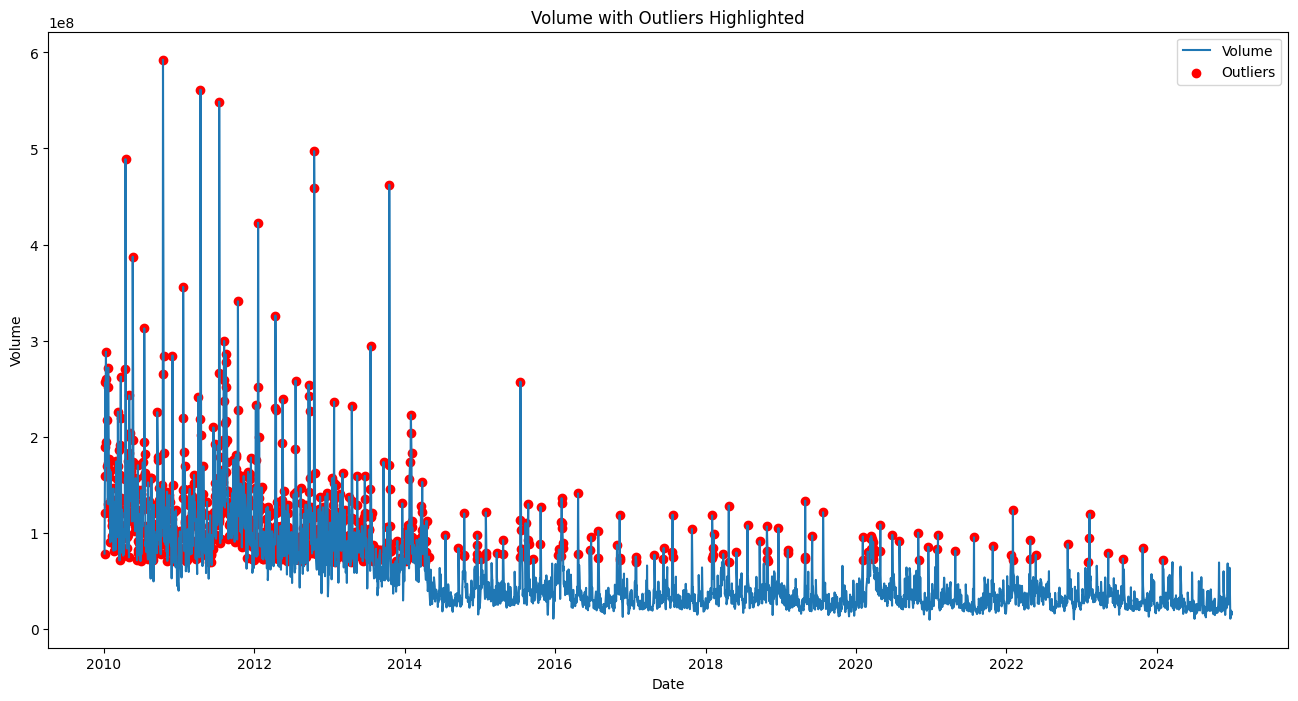

In [178]:
plt.figure(figsize=(16, 8))
sns.lineplot(x=google_data['Date'], y=google_data['Volume'], label='Volume')
outlier_dates = google_data[google_data['Volume'] > (Q3['Volume'] + 1.5 * IQR['Volume'])].index
plt.scatter(google_data['Date'].iloc[outlier_dates], google_data['Volume'].iloc[outlier_dates], color='red', label='Outliers')
plt.title('Volume with Outliers Highlighted')
plt.legend()

Text(0.5, 1.0, 'Histogram of Stock Closing Prices')

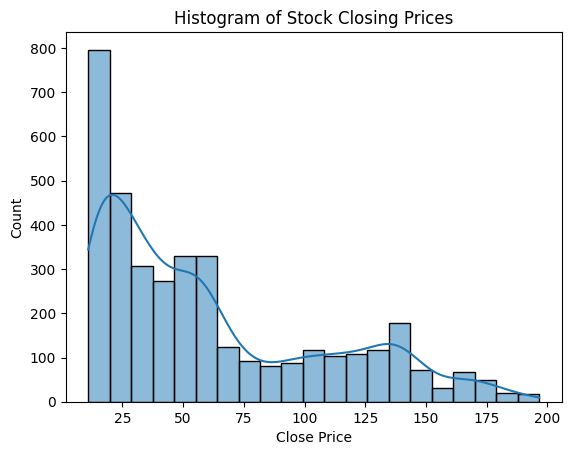

In [179]:
sns.histplot(google_data['Close Price'], kde=True)  # kde=True adds a density curve
plt.title('Histogram of Stock Closing Prices')

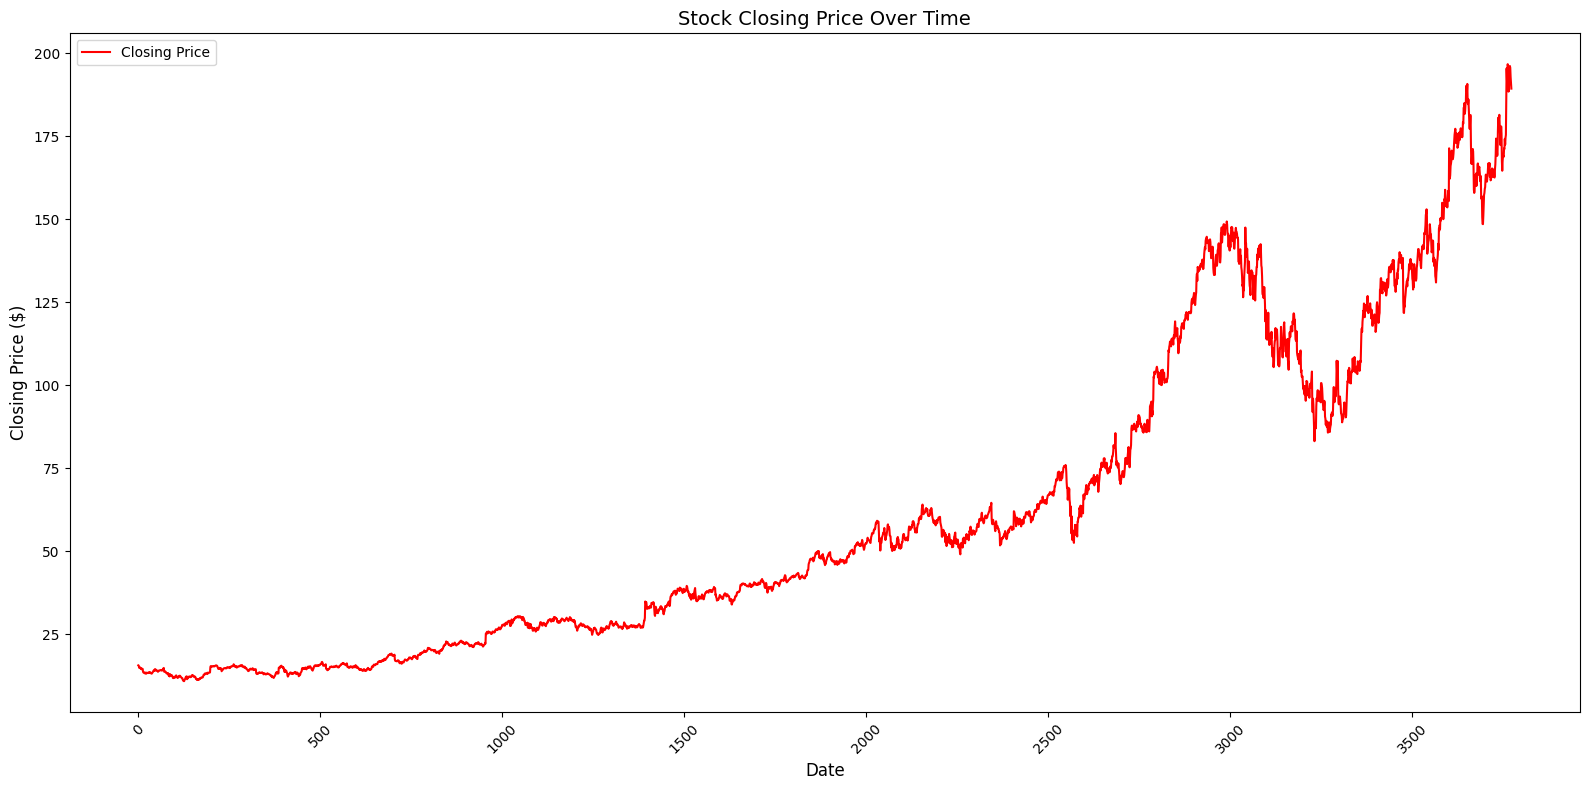

In [180]:
plt.figure(figsize=(16, 8))
plt.plot(google_data.index, google_data['Close Price'], label='Closing Price', color='red')
plt.title('Stock Closing Price Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price ($)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

Text(0.5, 1.0, 'Apple Trading Volume (1J024 - 1\x02\x825)')

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2 () missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


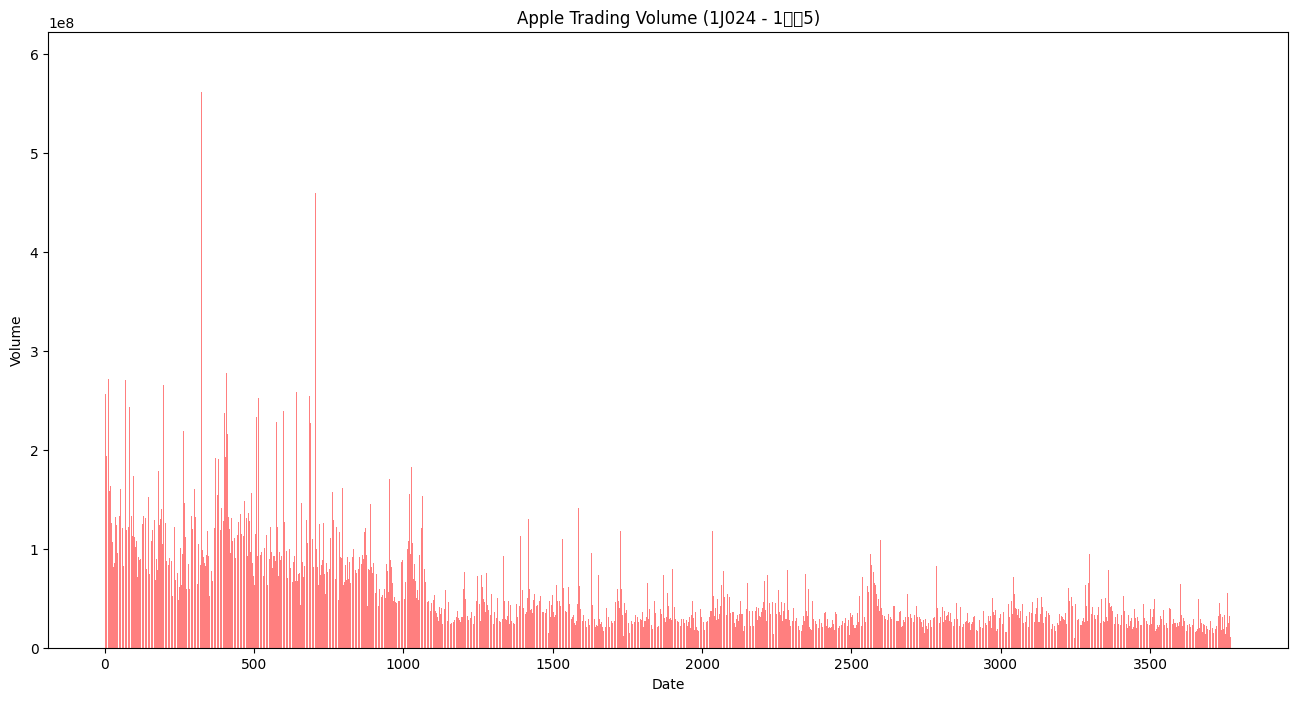

In [181]:
plt.figure(figsize=(16, 8))
plt.bar(google_data.index, google_data["Volume"], color='red', alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Apple Trading Volume (1\112024 - 1\2\2025)")

## **Microsoft**

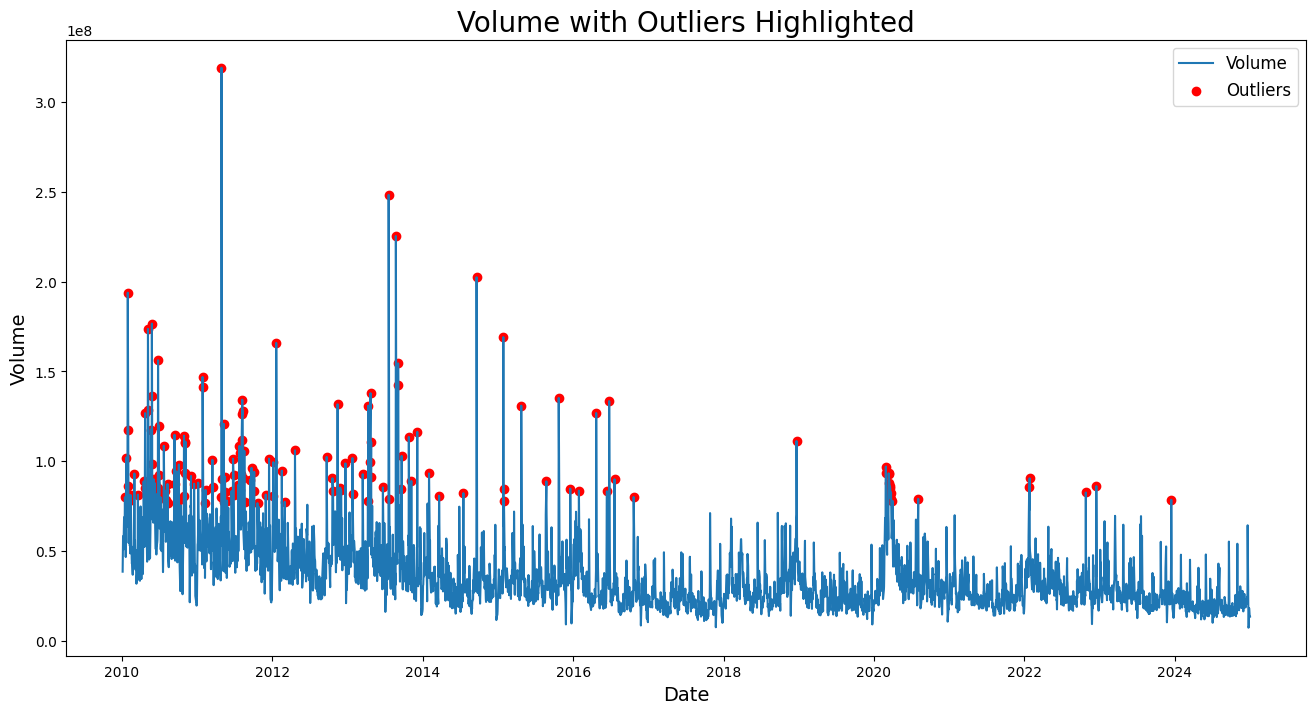

In [182]:
plt.figure(figsize=(16, 8))
sns.lineplot(x=microsoft_data['Date'], y=microsoft_data['Volume'], label='Volume')
Q1 = microsoft_data['Volume'].quantile(0.25)
Q3 = microsoft_data['Volume'].quantile(0.75)
IQR = Q3 - Q1
outlier_dates = microsoft_data[microsoft_data['Volume'] > (Q3 + 1.5 * IQR)].index
plt.scatter(microsoft_data['Date'].iloc[outlier_dates], microsoft_data['Volume'].iloc[outlier_dates], color='red', label='Outliers')
plt.title('Volume with Outliers Highlighted', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.legend(fontsize=12)

Text(0.5, 1.0, 'Histogram of Stock Closing Prices')

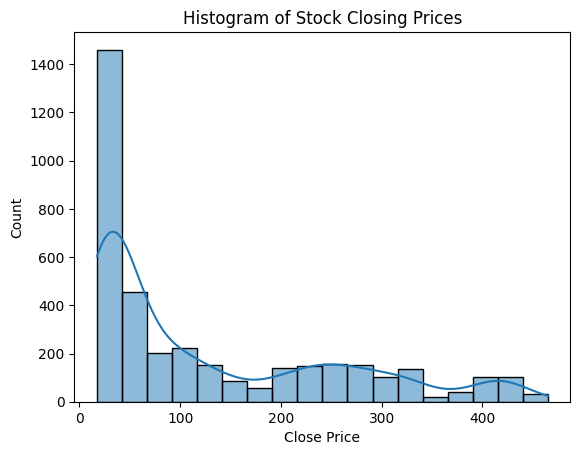

In [183]:
sns.histplot(microsoft_data['Close Price'], kde=True)  # kde=True adds a density curve
plt.title('Histogram of Stock Closing Prices')

Text(0.5, 1.0, 'Apple Trading Volume (1J024 - 1\x02\x825)')

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2 () missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


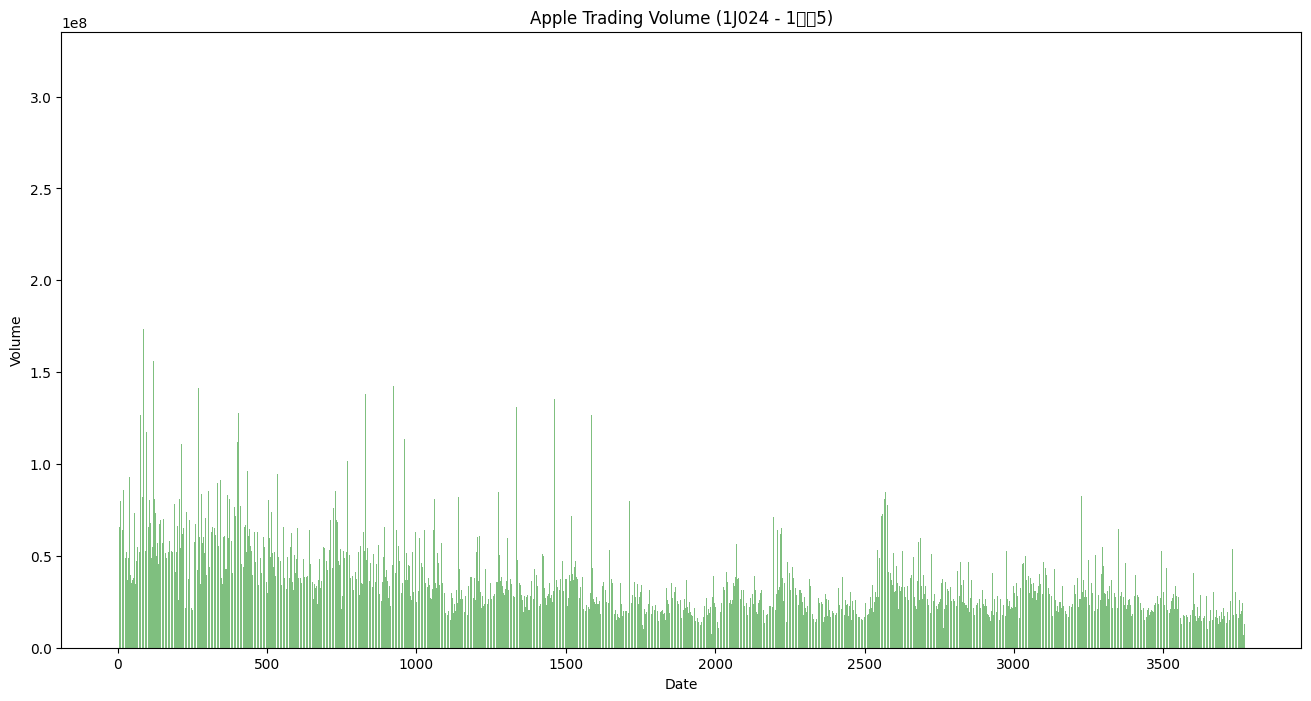

In [184]:
plt.figure(figsize=(16, 8))
plt.bar(microsoft_data.index, microsoft_data["Volume"], color='green', alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Apple Trading Volume (1\112024 - 1\2\2025)")

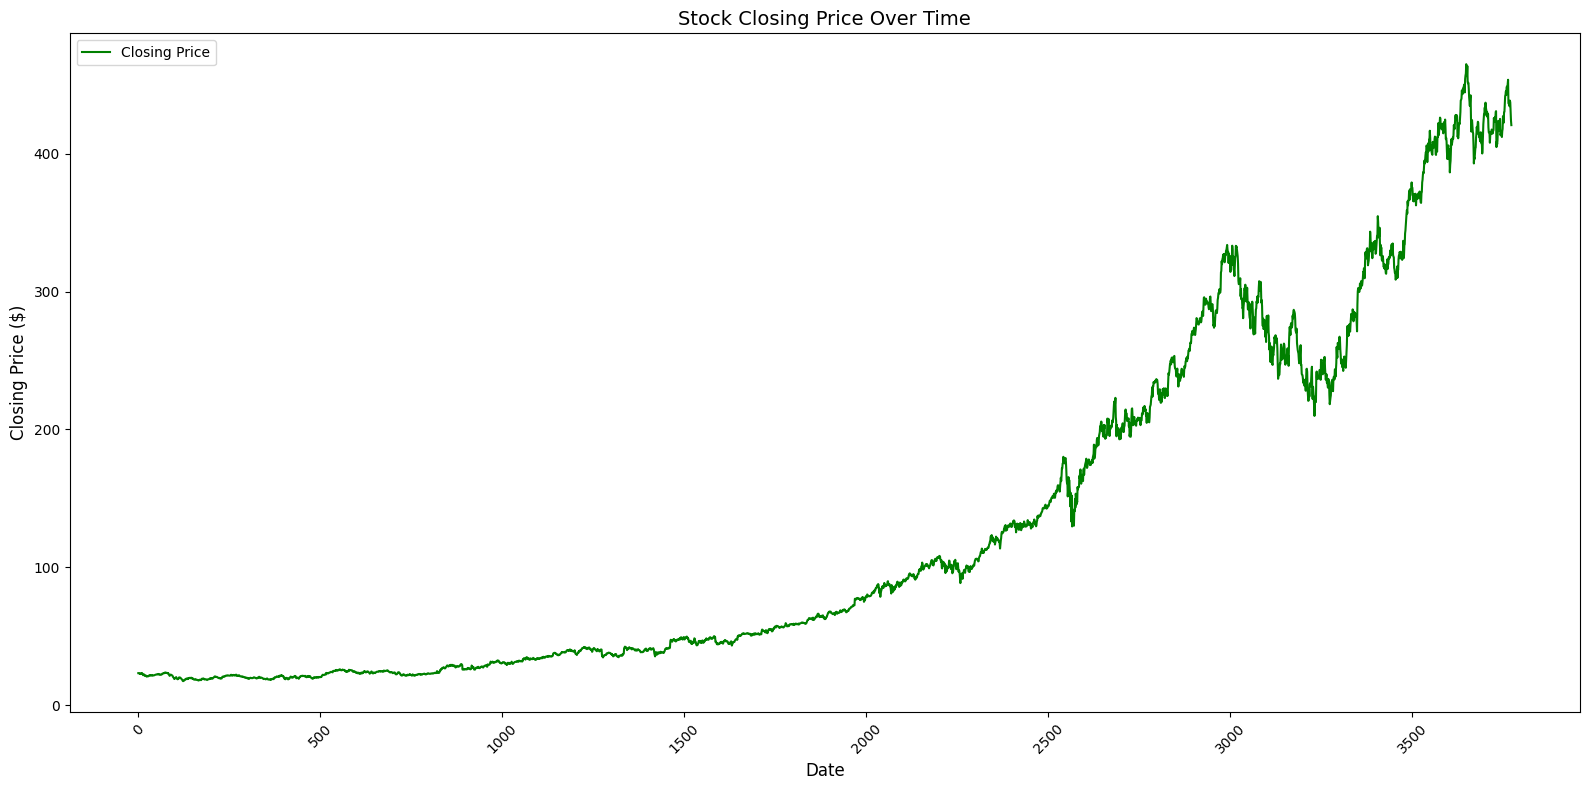

In [185]:
plt.figure(figsize=(16, 8))
plt.plot(microsoft_data.index, microsoft_data['Close Price'], label='Closing Price', color='green')
plt.title('Stock Closing Price Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price ($)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# **Set Date as index**

In [186]:
# Apple Data
apple_data["Date"] = pd.to_datetime(apple_data["Date"])
apple_data.set_index("Date", inplace=True)
apple_data.head()

,Open Price,Close Price,High Price,Low Price,Volume
Date,,,,,
2010-01-04,6.422877,6.440331,6.455077,6.391278,493729600
2010-01-05,6.458087,6.451467,6.487880,6.417460,601904800
2010-01-06,6.451466,6.348847,6.477046,6.342226,552160000
2010-01-07,6.372320,6.337111,6.379844,6.291067,477131200
2010-01-08,6.328684,6.379241,6.379843,6.291368,447610800


In [187]:
print(apple_data.index)

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2024-12-17', '2024-12-18', '2024-12-19', '2024-12-20',
               '2024-12-23', '2024-12-24', '2024-12-26', '2024-12-27',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=3774, freq=None)


In [188]:
# Google Data
google_data["Date"] = pd.to_datetime(google_data["Date"])
google_data.set_index("Date", inplace=True)
google_data.head()

,Open Price,Close Price,High Price,Low Price,Volume
Date,,,,,
2010-01-04,15.632768,15.627781,15.696601,15.565196,78169752
2010-01-05,15.638504,15.558962,15.654961,15.497873,120067812
2010-01-06,15.605590,15.166740,15.605590,15.119365,158988852
2010-01-07,15.195166,14.813666,15.210128,14.777512,256315428
2010-01-08,14.761303,15.011148,15.041817,14.689241,188783028


In [189]:
print(google_data.index)

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2024-12-17', '2024-12-18', '2024-12-19', '2024-12-20',
               '2024-12-23', '2024-12-24', '2024-12-26', '2024-12-27',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=3774, freq=None)


In [190]:
# Microsoft data
microsoft_data["Date"] = pd.to_datetime(microsoft_data["Date"])
microsoft_data.set_index("Date", inplace=True)
microsoft_data.head()

,Open Price,Close Price,High Price,Low Price,Volume
Date,,,,,
2010-01-04,23.006101,23.254044,23.366745,22.983560,38409100
2010-01-05,23.178921,23.261568,23.366757,23.021139,49749600
2010-01-06,23.201457,23.118811,23.351726,22.930975,58182400
2010-01-07,23.013615,22.878374,23.066210,22.683025,50559700
2010-01-08,22.750648,23.036158,23.201452,22.720594,51197400


In [191]:
print(microsoft_data.index)

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2024-12-17', '2024-12-18', '2024-12-19', '2024-12-20',
               '2024-12-23', '2024-12-24', '2024-12-26', '2024-12-27',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=3774, freq=None)


----------------

# **Buliding a LSTM model**

In [192]:
#Scaling the datasets
scaler_apple = MinMaxScaler(feature_range=(0, 1))
scaler_google = MinMaxScaler(feature_range=(0, 1))
scaler_microsoft = MinMaxScaler(feature_range=(0, 1))

apple_scaled = scaler_apple.fit_transform(apple_data[['Open Price', 'High Price', 'Low Price', 'Close Price']])
google_scaled = scaler_google.fit_transform(google_data[['Open Price', 'High Price', 'Low Price', 'Close Price']])
microsoft_scaled = scaler_microsoft.fit_transform(microsoft_data[['Open Price', 'High Price', 'Low Price', 'Close Price']])

In [193]:
def create_sequences(data, seq_length=40):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 3])
    return np.array(X), np.array(y)

X_apple, y_apple = create_sequences(apple_scaled)
X_google, y_google = create_sequences(google_scaled)
X_microsoft, y_microsoft = create_sequences(microsoft_scaled)

In [194]:
split_apple = int(0.8 * len(X_apple))
split_google = int(0.8 * len(X_google))
split_microsoft = int(0.8 * len(X_microsoft))

In [195]:
X_train_apple, y_train_apple = X_apple[:split_apple], y_apple[:split_apple]
X_test_apple, y_test_apple = X_apple[split_apple:], y_apple[split_apple:]

X_train_google, y_train_google = X_google[:split_google], y_google[:split_google]
X_test_google, y_test_google = X_google[split_google:], y_google[split_google:]

X_train_microsoft, y_train_microsoft = X_microsoft[:split_microsoft], y_microsoft[:split_microsoft]
X_test_microsoft, y_test_microsoft = X_microsoft[split_microsoft:], y_microsoft[split_microsoft:]

In [196]:
#Apple
print(f"X_train_apple shape: {X_train_apple.shape}")
print(f"y_train_apple shape: {y_train_apple.shape}")
print(f"X_test_apple shape: {X_test_apple.shape}")
print(f"y_test_apple shape: {y_test_apple.shape}")

X_train_apple shape: (2987, 40, 4)
y_train_apple shape: (2987,)
X_test_apple shape: (747, 40, 4)
y_test_apple shape: (747,)


In [197]:
# Google
print(f"X_train_google shape: {X_train_google.shape}")
print(f"y_train_google shape: {y_train_google.shape}")
print(f"X_test_google shape: {X_test_google.shape}")
print(f"y_test_google shape: {y_test_google.shape}")

X_train_google shape: (2987, 40, 4)
y_train_google shape: (2987,)
X_test_google shape: (747, 40, 4)
y_test_google shape: (747,)


In [198]:
#Microsoft
print(f"X_train_microsoft shape: {X_train_microsoft.shape}")
print(f"y_train_microsoft shape: {y_train_microsoft.shape}")
print(f"X_test_microsoft shape: {X_test_microsoft.shape}")
print(f"y_test_microsoft shape: {y_test_microsoft.shape}")

X_train_microsoft shape: (2987, 40, 4)
y_train_microsoft shape: (2987,)
X_test_microsoft shape: (747, 40, 4)
y_test_microsoft shape: (747,)


In [199]:
# LSTM Apple Model
model_apple = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_apple.shape[1], X_train_apple.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model_apple.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [200]:
#LSTM google
model_google = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_google.shape[1], X_train_google.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model_google.compile(optimizer='adam', loss='mse')

In [201]:
# LSTM Microsoft
model_microsoft = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_microsoft.shape[1], X_train_microsoft.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model_microsoft.compile(optimizer='adam', loss='mse')

In [202]:
model_apple.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 40, 50)              │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 40, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,501 (126.96 KB)

 Trainable params: 32,501 (126.96 KB)

 Non-trainable params: 0 (0.00 B)

In [203]:
model_google.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 40, 50)              │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 40, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,501 (126.96 KB)

 Trainable params: 32,501 (126.96 KB)

 Non-trainable params: 0 (0.00 B)

In [204]:
model_microsoft.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 40, 50)              │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 40, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,501 (126.96 KB)

 Trainable params: 32,501 (126.96 KB)

 Non-trainable params: 0 (0.00 B)

### **1. Apple**

In [205]:
history_apple = model_apple.fit(X_train_apple, y_train_apple, epochs=50, batch_size=32, validation_data=(X_test_apple, y_test_apple), verbose=1)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0067 - val_loss: 0.0017
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 5.7142e-04 - val_loss: 0.0013
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 4.0556e-04 - val_loss: 0.0013
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.1821e-04 - val_loss: 7.8368e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.3598e-04 - val_loss: 0.0023
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.7668e-04 - val_loss: 7.7779e-04
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3.8240e-04 - val_loss: 7.1593e-04
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.8159e-04 - val_loss: 0.0012
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.7983e-04 - val_loss: 0.0011
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.0773e-04 - val_loss: 6.4897e-04
Epoch 11/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.9128e-04 - val_loss: 9.3502e-04
Epo

In [206]:
summary_apple= pd.DataFrame(history_apple.history)
summary_apple.head()

,loss,val_loss
0,0.002512,0.001670
1,0.000537,0.001299
2,0.000412,0.001337
3,0.000390,0.000784
4,0.000324,0.002292


In [207]:
print("Training Loss: ", history_apple.history['loss'])
print("Validation Loss: ", history_apple.history['val_loss'])

Training Loss:  [0.002511783968657255, 0.0005365081015042961, 0.00041177854291163385, 0.0003895104746334255, 0.00032377283787354827, 0.00034990895073860884, 0.00038144554127939045, 0.00028860961901955307, 0.0002792099257931113, 0.00027549354126676917, 0.00026872940361499786, 0.00024253662559203804, 0.0002677193842828274, 0.00025993012241087854, 0.00026669431827031076, 0.0002383015089435503, 0.00026862730737775564, 0.00022896395239513367, 0.0002442591649014503, 0.0002326000976609066, 0.00028997944900766015, 0.00027002894785255194, 0.0002257170417578891, 0.00026596381212584674, 0.00025652351905591786, 0.0002710800035856664, 0.0002427857689326629, 0.00022554716269951314, 0.00024446731549687684, 0.0002480929542798549, 0.00023889270960353315, 0.00023819779744371772, 0.0002065115695586428, 0.00022523610095959157, 0.00024452360230498016, 0.00021542186732403934, 0.0002751974971033633, 0.00023617940314579755, 0.00022352834639605135, 0.00021286081755533814, 0.00022944204101804644, 0.000222705886

In [208]:
predictions_apple = model_apple.predict(X_test_apple)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [209]:
predictions_apple = predictions_apple.reshape(-1, 1)
y_test_apple = y_test_apple.reshape(-1, 1)

predicted_apple_prices = scaler_apple.inverse_transform(
    np.concatenate((np.zeros((predictions_apple.shape[0], X_test_apple.shape[2] - 1)), predictions_apple), axis=1)
)[:, -1]

actual_apple_prices = scaler_apple.inverse_transform(
    np.concatenate((np.zeros((y_test_apple.shape[0], X_test_apple.shape[2] - 1)), y_test_apple), axis=1)
)[:, -1]

In [210]:
# Printing some values for verification
print(f"First 5 predicted values: {predicted_apple_prices[:5]}")
print(f"First 5 actual values: {actual_apple_prices[:5]}")

First 5 predicted values: [172.05822236 171.2182328  171.22651027 171.192933   170.8749516 ]
First 5 actual values: [172.0690918  172.51135254 169.22879028 170.09367371 166.87989807]


In [211]:
mae_apple = mean_absolute_error(actual_apple_prices, predicted_apple_prices)
rmse_apple = np.sqrt(mean_squared_error(actual_apple_prices, predicted_apple_prices))
mape_apple = np.mean(np.abs((actual_apple_prices - predicted_apple_prices) / actual_apple_prices)) * 100
r2_apple = r2_score(actual_apple_prices, predicted_apple_prices)

In [212]:
print(f"Apple Evaluation:")
print(f"MAE  : {mae_apple:.4f}")
print(f"RMSE : {rmse_apple:.4f}")
print(f"MAPE : {mape_apple:.2f}%")
print(f"R² Score : {r2_apple:.4f}")

Apple Evaluation:
MAE  : 3.8930
RMSE : 4.9148
MAPE : 2.22%
R² Score : 0.9726


In [213]:
final_train_loss = history_apple.history['loss'][-1]
final_test_loss = history_apple.history['val_loss'][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Test Loss: {final_test_loss:.4f}")

Final Training Loss: 0.0003
Final Test Loss: 0.0004


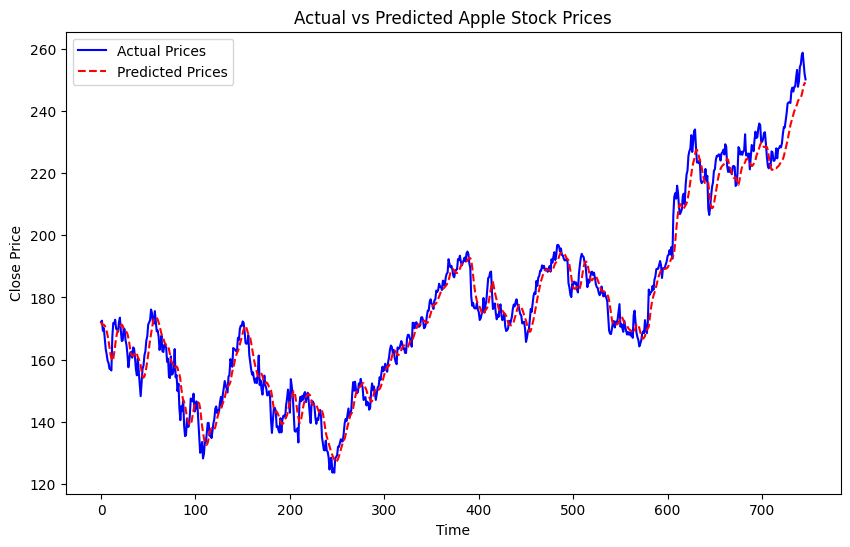

In [214]:
plt.figure(figsize=(10, 6))
plt.plot(actual_apple_prices, label="Actual Prices", color='blue')
plt.plot(predicted_apple_prices, label="Predicted Prices", color='red', linestyle='--')
plt.title("Actual vs Predicted Apple Stock Prices")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()

## **2. Google**

In [215]:
history_google = model_google.fit(X_train_google, y_train_google, epochs=50, batch_size=32, validation_data=(X_test_google, y_test_google), verbose=1)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0102 - val_loss: 8.9379e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.7232e-04 - val_loss: 8.5463e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 5.0364e-04 - val_loss: 0.0022
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 4.9821e-04 - val_loss: 0.0012
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 4.6153e-04 - val_loss: 9.9810e-04
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 3.9740e-04 - val_loss: 0.0013
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 3.4646e-04 - val_loss: 0.0012
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.9955e-04 - val_loss: 0.0029
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.0951e-04 - val_loss: 0.0011
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3.6351e-04 - val_loss: 7.9772e-04
Epoch 11/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.9491e-04 - val_loss: 0.0018
Epoch 1

In [216]:
summary_google= pd.DataFrame(history_google.history)
summary_google.head()

,loss,val_loss
0,0.003431,0.000894
1,0.000633,0.000855
2,0.000518,0.002203
3,0.000438,0.001216
4,0.000459,0.000998


In [217]:
predictions_google = model_google.predict(X_test_google)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [218]:
predictions_google = predictions_google.reshape(-1, 1)
y_test_google = y_test_google.reshape(-1, 1)

predicted_google_prices = scaler_google.inverse_transform(
    np.concatenate((np.zeros((predictions_google.shape[0], X_test_google.shape[2] - 1)), predictions_google), axis=1)
)[:, -1]

actual_google_prices = scaler_google.inverse_transform(
    np.concatenate((np.zeros((y_test_google.shape[0], X_test_google.shape[2] - 1)), y_test_google), axis=1)
)[:, -1]

In [219]:
print(f"First 5 predicted values: {predicted_google_prices[:5]}")
print(f"First 5 actual values: {actual_google_prices[:5]}")

First 5 predicted values: [137.97743691 137.18791149 137.26211672 137.49407863 137.41845597]
First 5 actual values: [139.23126221 140.91966248 138.08642578 138.97669983 135.5067749 ]


In [220]:
mae_google = mean_absolute_error(actual_google_prices, predicted_google_prices)
rmse_google = np.sqrt(mean_squared_error(actual_google_prices, predicted_google_prices))
mape_google = np.mean(np.abs((actual_google_prices - predicted_google_prices) / actual_google_prices)) * 100
r2_google = r2_score(actual_google_prices, predicted_google_prices)

In [221]:
print(f"Google Evaluation:")
print(f"MAE : {mae_google:.4f}")
print(f"RMSE : {rmse_google:.4f}")
print(f"MAPE : {mape_google:.2f}%")
print(f"R² Score : {r2_google:.4f}")

Google Evaluation:
MAE : 3.6946
RMSE : 4.6543
MAPE : 2.77%
R² Score : 0.9712


In [222]:
final_train_loss = history_google.history['loss'][-1]
final_test_loss = history_google.history['val_loss'][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Test Loss: {final_test_loss:.4f}")

Final Training Loss: 0.0003
Final Test Loss: 0.0006


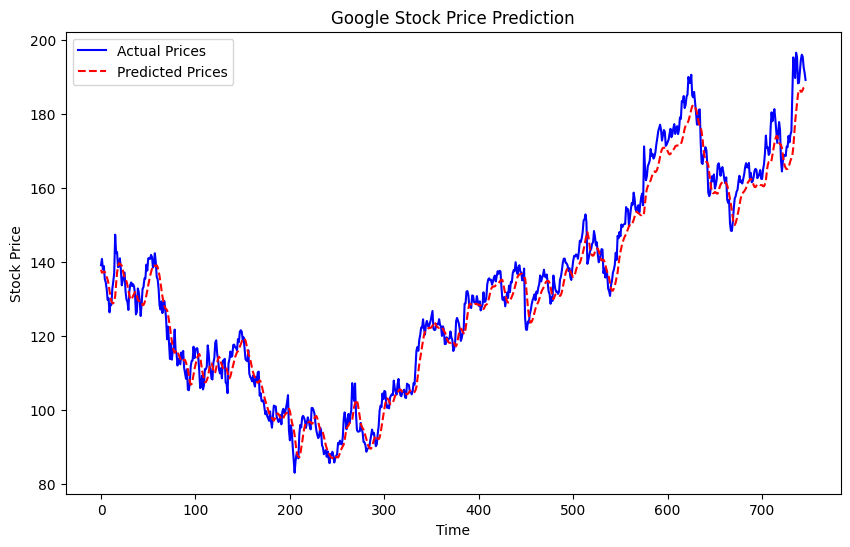

In [223]:
plt.figure(figsize=(10, 6))
plt.plot(actual_google_prices, label="Actual Prices", color='blue')
plt.plot(predicted_google_prices, label="Predicted Prices", color='red', linestyle='--')
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()

## **3. Microsoft**

In [224]:
history_microsoft = model_microsoft.fit(X_train_microsoft, y_train_microsoft, epochs=50, batch_size=32, validation_data=(X_test_microsoft, y_test_microsoft), verbose=1)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0091 - val_loss: 8.3525e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 5.4874e-04 - val_loss: 0.0014
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 4.6141e-04 - val_loss: 0.0028
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.3089e-04 - val_loss: 0.0033
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 3.6078e-04 - val_loss: 6.6177e-04
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.7258e-04 - val_loss: 8.1739e-04
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.4160e-04 - val_loss: 0.0013
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 3.2655e-04 - val_loss: 0.0026
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.7668e-04 - val_loss: 8.5257e-04
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 3.2304e-04 - val_loss: 0.0034
Epoch 11/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.1541e-04 - val_loss: 9.7903e-04
Epo

In [225]:
summary_microsoft= pd.DataFrame(history_microsoft.history)
summary_microsoft.head()

,loss,val_loss
0,0.003190,0.000835
1,0.000533,0.001357
2,0.000453,0.002838
3,0.000418,0.003313
4,0.000385,0.000662


In [226]:
predictions_microsoft = model_microsoft.predict(X_test_microsoft)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [227]:
predictions_microsoft = predictions_microsoft.reshape(-1, 1)
y_test_microsoft = y_test_microsoft.reshape(-1, 1)

predicted_microsoft_prices = scaler_microsoft.inverse_transform(
    np.concatenate((np.zeros((predictions_microsoft.shape[0], X_test_microsoft.shape[2] - 1)), predictions_microsoft), axis=1)
)[:, -1]

actual_microsoft_prices = scaler_microsoft.inverse_transform(
    np.concatenate((np.zeros((y_test_microsoft.shape[0], X_test_microsoft.shape[2] - 1)), y_test_microsoft), axis=1)
)[:, -1]

In [228]:
print(f"First 5 predicted values: {predicted_microsoft_prices[:5]}")
print(f"First 5 actual values: {actual_microsoft_prices[:5]}")

First 5 predicted values: [310.24299786 307.53867142 306.58528095 305.2875328  303.59321198]
First 5 actual values: [306.40313721 309.60351562 296.50030518 301.75326538 294.40884399]


In [229]:
mae_microsoft = mean_absolute_error(actual_microsoft_prices, predicted_microsoft_prices)
rmse_microsoft = np.sqrt(mean_squared_error(actual_microsoft_prices, predicted_microsoft_prices))
mape_microsoft = np.mean(np.abs((actual_microsoft_prices - predicted_microsoft_prices) / actual_microsoft_prices)) * 100
r2_microsoft = r2_score(actual_microsoft_prices, predicted_microsoft_prices)

In [230]:
print(f"Microsoft Evaluation:")
print(f"MAE  : {mae_microsoft:.4f}")
print(f"RMSE : {rmse_microsoft:.4f}")
print(f"MAPE : {mape_microsoft:.2f}%")
print(f"R² Score : {r2_microsoft:.4f}")

Microsoft Evaluation:
MAE  : 8.9947
RMSE : 11.1451
MAPE : 2.66%
R² Score : 0.9758


In [231]:
final_train_loss = history_microsoft.history['loss'][-1]
final_test_loss = history_microsoft.history['val_loss'][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Test Loss: {final_test_loss:.4f}")

Final Training Loss: 0.0003
Final Test Loss: 0.0006


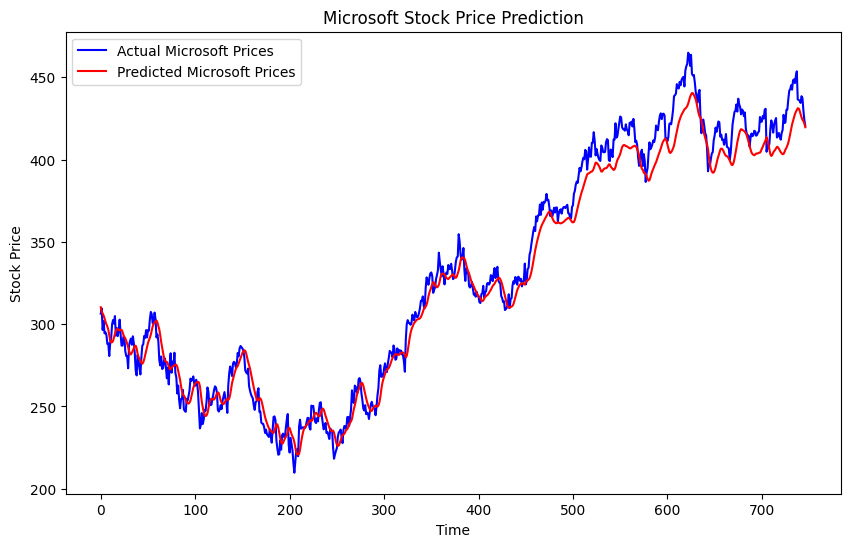

In [232]:
plt.figure(figsize=(10, 6))
plt.plot(actual_microsoft_prices, color='blue', label='Actual Microsoft Prices')
plt.plot(predicted_microsoft_prices, color='red', label='Predicted Microsoft Prices')
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

# **Compare the companies preformence**

In [233]:
import pandas as pd

df = pd.DataFrame(companies).T
df.index.name = 'Company'
df = df[['MAE', 'RMSE', 'MAPE', 'R2']]
print(df)

                 MAE       RMSE      MAPE        R2
Company                                            
Microsoft  10.981541  13.267683  3.255543  0.965742
Google      4.230283   5.284905  3.168666  0.962876
Apple       4.421449   5.597907  2.448768  0.964483


In [234]:
companies = {
    "Microsoft": {"MAE": mae_microsoft, "RMSE": rmse_microsoft, "MAPE": mape_microsoft, "R2": r2_microsoft},
    "Google": {"MAE": mae_google, "RMSE": rmse_google, "MAPE": mape_google, "R2": r2_google},
    "Apple": {"MAE": mae_apple, "RMSE": rmse_apple, "MAPE": mape_apple, "R2": r2_apple},
}

best_mae = min(companies, key=lambda x: companies[x]["MAE"])
print(f"Best MAE: {best_mae} ({companies[best_mae]['MAE']:.4f})")
best_rmse = min(companies, key=lambda x: companies[x]["RMSE"])
print(f"Best RMSE: {best_rmse} ({companies[best_rmse]['RMSE']:.4f})")
best_mape = min(companies, key=lambda x: companies[x]["MAPE"])
print(f"Best MAPE: {best_mape} ({companies[best_mape]['MAPE']:.2f}%)")
best_r2 = max(companies, key=lambda x: companies[x]["R2"])
print(f"Best R² Score: {best_r2} ({companies[best_r2]['R2']:.4f})")

Best MAE: Google (3.6946)
Best RMSE: Google (4.6543)
Best MAPE: Apple (2.22%)
Best R² Score: Microsoft (0.9758)


In [235]:
mae_rank = sorted(companies.items(), key=lambda x: x[1]['MAE'])
rmse_rank = sorted(companies.items(), key=lambda x: x[1]['RMSE'])
mape_rank = sorted(companies.items(), key=lambda x: x[1]['MAPE'])
r2_rank = sorted(companies.items(), key=lambda x: x[1]['R2'], reverse=True)

print("\nCompany Rankings (Lower is Better for MAE, RMSE, MAPE; Higher is Better for R²):\n")
print("By MAE:", [x[0] for x in mae_rank])
print("By RMSE:", [x[0] for x in rmse_rank])
print("By MAPE:", [x[0] for x in mape_rank])
print("By R²:", [x[0] for x in r2_rank])


Company Rankings (Lower is Better for MAE, RMSE, MAPE; Higher is Better for R²):

By MAE: ['Google', 'Apple', 'Microsoft']
By RMSE: ['Google', 'Apple', 'Microsoft']
By MAPE: ['Apple', 'Microsoft', 'Google']
By R²: ['Microsoft', 'Apple', 'Google']


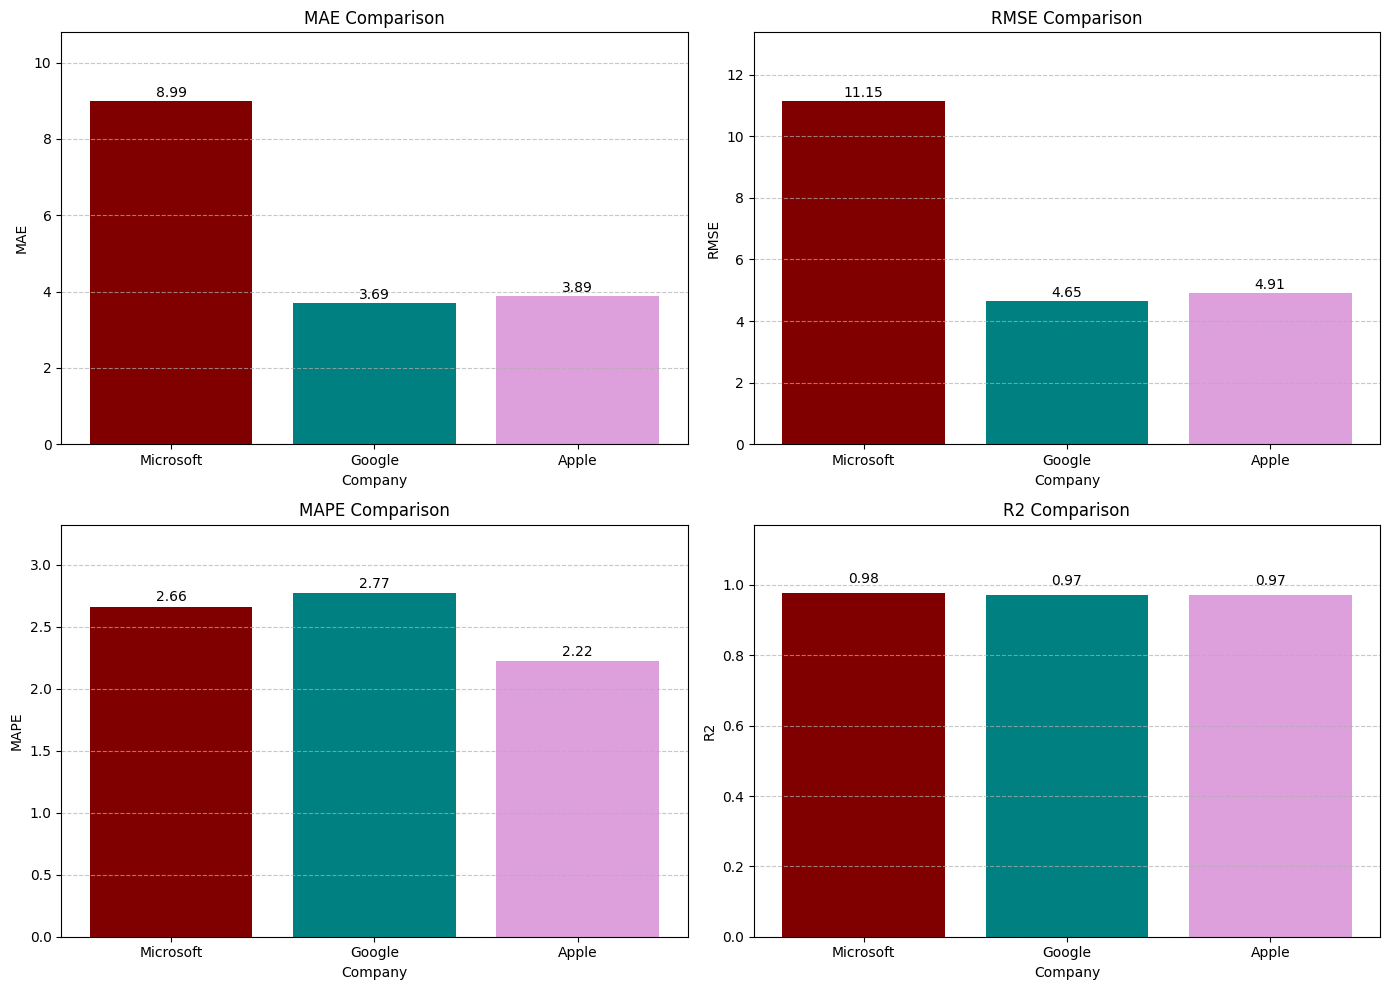

In [236]:
metrics_names = ["MAE", "RMSE", "MAPE", "R2"]
companies_list = list(companies.keys())
custom_palette = ["maroon", "teal", "plum"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics_names):
    values = [companies[company][metric] for company in companies_list]
    axes[i].bar(companies_list, values, color=custom_palette[:len(companies_list)])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('Company')
    axes[i].grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
    axes[i].set_ylim(0, max(max(values) * 1.2, 1))
    for j, value in enumerate(values):
        axes[i].text(j, value + 0.02, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


#**Saving The model**

In [237]:
model_apple.save('model_apple.h5')
model_google.save('model_google.h5')
model_microsoft.save('model_microsoft.h5')